# アジェンダ
* アクティベーション分布
* Batch Normalization
* Weight decay
* Dropout

テキスト範囲  
第６章　P177 ~ P203

# 機械学習に必要な準備

In [1]:
# 必要なモジュールの読み込み
import numpy as np
import matplotlib.pyplot as plt
import sys, os

%matplotlib inline

In [2]:
# パスの追加
sys.path.append('../Chapter_5/Non_Demo')
# 今までに作成したクラスの読み込み
from Layers import *
from TwoLayerNet import TwoLayerNet
from function import function
# インスタンスの作成
net = TwoLayerNet(input_size=784, hidden_size=5, output_size=10)
func = function()

# アクティベーション分布

### 重み係数は小さい方がいい  
→ すべて0にすれば良いのでは？  
→ 重みを均一な値に設定してはいけない  
→ 仮に、第１層から第２層へのすべての重みが0だとすると、第２層への順伝播ではすべてのノードで同じ値が入力されることになる  
→ 逆伝播では、第２層の重みがすべて同じように更新されてしまう  
→ 層を重ねることに意味がない  

### アクティベーションとは
活性化関数の後の出力データを指す。  
つまり、第$n$層の出力データであり、第$n+1$層の入力データを指す。

In [3]:
# アクティベーションの描画関数

def activations(std_defo = 1, func_type = 'sigmoid'):
    x = np.random.randn(1000,100)   # 適当な入力値を作成
    node_num = 100                             # 各隠れ層のノード数（すべての層でノード数は均一だとする）
    hidden_layer_size = 5                     # 隠れ層が５層
    activations = {}                                # ここにアクティベーションの結果を格納する

    for i in range(hidden_layer_size):
        if i != 0:
            x = activations[i-1]                                                         # 入力値として前層のアクティベーションを利用

        std = std_defo                                                                    # 標準偏差std を変化させることで、アクティベーション分布がどのように変わるのかを検証
        w = np.random.randn(node_num, node_num) * std      # 重みをランダムに作成（サイズは各層のノード数に依るが、今回は正方行列になる）

        # 順伝播の実行
        z = np.dot(x,w)
        
        if func_type == 'sigmoid':
            a = func.sigmoid(z)
        else:
            a = func.ReLU(z)
            
        activations[i] = a

     # ヒストグラムを描画
    plt.figure(figsize=(16,4))
    for i, a in activations.items():
        plt.subplot(1, len(activations), i+1)
        plt.title(str(i+1) + '_layer, std = ' + str(std))
        plt.hist(a.flatten(), bins = 30, range=(0,1))
        plt.tight_layout()

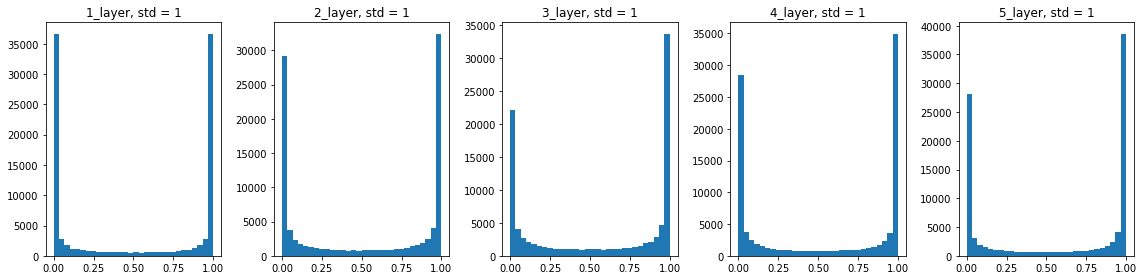

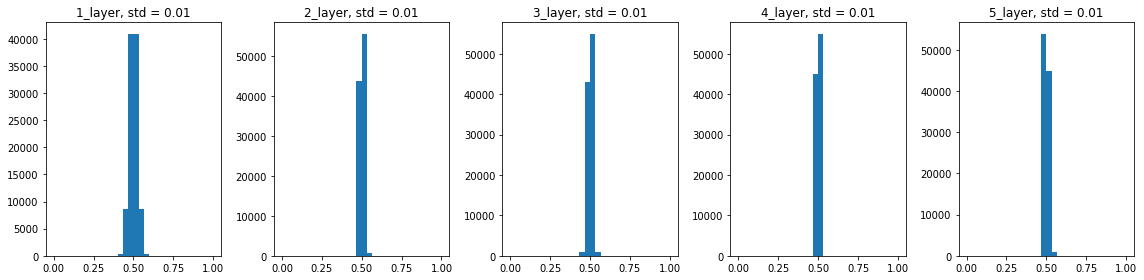

In [4]:
# アクティベーション分布の描画
activations(1, 'sigmoid')
activations(0.01, 'sigmoid')

### std = 1 の場合のアクティベーション分布
各層のアクティベーション分布を見ると、0と1に偏った分布になっていることが分かる。  
活性化関数にはS字カーブのシグモイド関数を用いているため、0と1付近では勾配が0に近くなる。  
そのため、層を深くするにつれて勾配がどんどん小さくなって（勾配消失）いき、最終的には学習が進まなくなる。  

### std = 0.01 の場合のアクティベーション分布
各層のアクティベーションが0.5付近に集中しているため、勾配消失が起こらない。  
しかし、集中していること自体、問題でもある。  
→複数のニューロンがほとんど同じ値を出力するのであれば、単一のニューロンで実現可能になってしまう。  
→表現力の面で課題になる。  

### Xavierの初期値
前層のノード数を$n$とした場合、
$$ std = \frac{1}{\sqrt{n}} $$
ただし、このXavierの初期値は活性化関数が線形であることを前提に導かれたものであることに留意する。

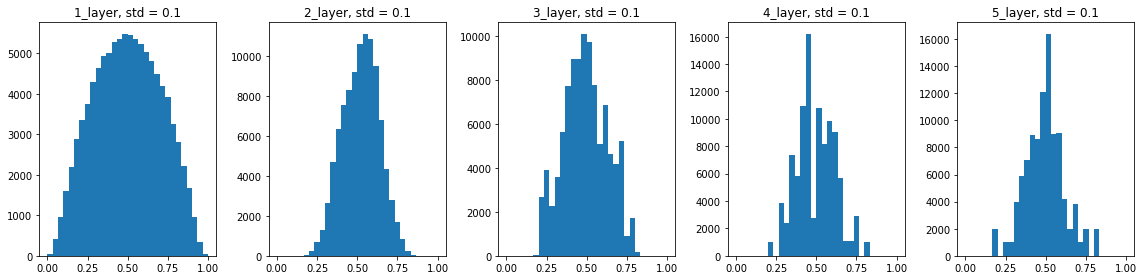

In [5]:
# Xavierの初期値を用いた場合のアクティベーション分布
activations(1/np.sqrt(100), 'sigmoid')

層が進むにつれて、ややいびつな形になるが、これまでよりも広がりを持った分布になっていることが分かる。

### Heの初期値
「Xavierの初期値」は、活性関数が線形であることを前提に導いた結果
→シグモイド関数は左右対称で中心付近では線形関数として見なせる。
→ ReLU関数を用いる場合には適さない。

$$ std = \frac{2}{\sqrt{n}} $$

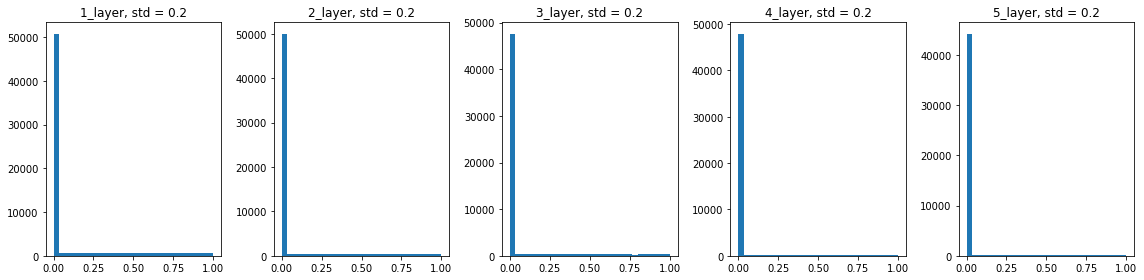

In [6]:
activations(2/np.sqrt(100), 'ReLU')

Heの初期値を用いた場合、各層での分布が一様になっており、層を深くしても広がりが保てていることが分かる。  
→ 勾配消失が起こらない。

### 初期値に応じた学習推移
<img src="activation.png" width="500" height="500">

### アクティベーションのまとめ
1. 重みは均一な値をとってはいけない
2. 層が深くなるにつれて勾配が0に近づいていくことを「勾配消失」という
3. ガウス分布で重みの初期値を作成する場合は、標準分布の値が重要になる
 * 活性化関数が線形：Xavierの初期値
 * 活性化関数が非線形：Heの初期値

# Batch Normalization


### Batch Normalizationとは
無理やりアクティベーションの分布を調整したらいいんじゃないのか？
→ミニバッチごとに正則化を行う（データの分布が、平均0 , 分散1になるようにする）

$$ \mu_B ← \frac{1}{m}\sum_{i=1}^{m}{x_i}\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,$$
$$ \sigma_B^2 ← \frac{1}{m}\sum_{i=1}^{m}{(x_i-\mu_B)}^2$$

$$ \hat{x}_i ← \frac{x_i-\mu_B}{\sqrt{\sigma_B^2+\varepsilon}} \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,$$

詳しくは以下のURLを参照してください。  
[Batch Normalization](https://qiita.com/t-tkd3a/items/14950dbf55f7a3095600)


<img src=Batch_Normalization.png width=500>

### Batch Normalizationのまとめ
1. 学習を早く進行させることができる(学習係数を大きくすることができる)
2. 初期値にそれほど依存しない(初期値に対してそこまで神経質にならなくても良い)
3. 過学習を抑制する(後述のDropoutなどの必要性を減らす)
4. ミニバッチごとに正則化を行う

# Weight decay(荷重減衰)

ニューラルネットワークの学習の目標は、損失関数の値を最小化すること  
→ 重みの２乗ノルムを損失関数に加算することで、重みが大きくなりすぎることを抑制する。

$$ \frac{1}{2}\lambda \boldsymbol{W^2} = \frac{1}{2}\lambda(w_1^2+w_2^2+\cdots + w_n^2)$$

$\lambda$は正則化の強さをコントロールするハイパーパラメータ  
→ $\lambda$を大きく設定すればするほど、大きな重みを取ることに対して強いペナルティとなる

<table>
<tr　　style="background-color:#FFFFFF;">
<td><img src=non_weight_decay.png></td>
<td><img src=weight_decay.png></td>
</tr>
</table>

左がWeight decayなしの学習結果、右がWeight decayありの学習結果  
→ 訓練データの精度が100%に到達しなくなった  
→ 訓練データでの精度と試験データでの精度との隔たりが小さくなっている

→ 過学習が抑制されている

# Dropout

ニューロンをランダムに消去しながら学習する手法  
→ 訓練時には、データが流れるたびに消去するニューロンをランダムに選択する 
→ テスト時にはすべてのニューロンの信号を伝達する（訓練時に消去した割合を乗じて出力）

In [7]:
class Dropout:
    def __init__(self, dropout_ratio = 0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
        
    def forward(self, x, train_flg = True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1 - self.dropout_ratio)
        
    def backward(self, dout):
        return dout * self.mask

順伝播の度に、self.maskに消去するニューロンをFalseとして格納  
→ 順伝播では、単に入力をそのまま流すだけで良い  
→ 逆伝播では、ReLUレイヤと同様の挙動を振る舞う  
→ 順伝播で信号を流したニューロンは逆伝播でもそのまま流し、順伝播で信号を止めたニューロンは逆伝播でもストップさせる

<img src='Dropout.png' width='500' height='500'>